In [65]:
%matplotlib inline

from model import pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
import model.pandas as mpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import fbeta_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn.metrics as metrics
sns.set()

In [4]:
def quantileEncoder(cols, target, qs, qnames = None):
    if qnames is None:
        qnames = [f"{'_'.join(cols)}_encode_{q * 100}%" for q in qs]
    
    def quantileFun(df):
        return df.groupby(cols)[target]\
                .quantile(qs)\
                .unstack()\
                .rename({q : qname for q, qname in zip(qs, qnames)}, axis = 1)
                
    return mpd.joinFun(quantileFun, on = cols, how = 'left')

In [5]:
def dateDecoder(date_col):
    d1 = mpd.columnMapper(lambda x: x.dt.dayofweek, date_col, 'dow')
    d2 = mpd.columnMapper(lambda x: x.dt.month, date_col, 'month')
    
    return pipeline([d1, d2])

def timeDecoder(time_col):
    t1 = mpd.columnMapper(lambda x: x.str.extract('([0-9]+):[0-9]+', expand = False).astype('int'),
                     time_col, 'hour')
    t2 = mpd.columnMapper(lambda x: x.str.extract('[0-9]+:([0-9]+)', expand = False).astype('int'),
                     time_col, 'minute')
    
    return t1

In [6]:
class E(mpd.Estimator):
    def __init__(self, fit_trans):
        self.fit_trans = fit_trans
    
    def fit(self, df):
        t, _ = self.fit_trans
        return t
    
    def fit_transform(self, df):
        return self.fit_trans(df)

def regularizedQuanitleEncoding(cols, target, qs, qnames = None, splits = 5):
    if qnames is None:
        qnames = [f"{'_'.join(cols)}_encode_{q * 100}%" for q in qs]
        
    def fit_qenc(train):
        folder = KFold(n_splits=splits)
        train_enc = []
        
        for cv_train_ids, cv_val_ids in folder.split(train):
            cv_train = train.iloc[cv_train_ids]
            cv_val = train.iloc[cv_val_ids]
            
            cv_quanitles = cv_train.groupby(cols)[target]\
                .quantile(qs)\
                .unstack()\
                .rename({q : qname for q, qname in zip(qs, qnames)}, axis = 1)
            
            train_enc = train_enc + [cv_val.join(cv_quanitles, on = cols, how = 'left')]
        
        means = train.groupby(cols)[target]\
            .quantile(qs)\
            .unstack()\
            .rename({q : qname for q, qname in zip(qs, qnames)}, axis = 1)
        
        return mpd.MapT(lambda df: df.join(means, on = cols, how = 'left')), pd.concat(train_enc)
        
    return E(fit_qenc)

In [7]:
def regularizedStuff(cols, target, rsuffix = None, splits = 5):
    if rsuffix is None:
        rsuffix = ''
        
    def fit_qenc(train):
        folder = KFold(n_splits=splits)
        train_enc = []
        
        for cv_train_ids, cv_val_ids in folder.split(train):
            cv_train = train.iloc[cv_train_ids]
            cv_val = train.iloc[cv_val_ids]
            
            cv_means = cv_train.groupby(cols)[target]\
                .agg(['mean', 'std', 'count'])
            
            cv_means = cv_means.rename({col : '_'.join(cols) + '_' + target + '_' + col + rsuffix for col in cv_means.columns}, axis = 1)
            
            train_enc = train_enc + [cv_val.join(cv_means, on = cols, how = 'left')]
        
        means = train.groupby(cols)[target]\
            .agg(['mean', 'std', 'count'])
        
        means = means.rename({col : '_'.join(cols) + '_' + target + '_' + col + rsuffix for col in means.columns}, axis = 1)
        return mpd.MapT(lambda df: df.join(means, on = cols, how = 'left')), pd.concat(train_enc)
        
    return E(fit_qenc)

In [73]:
data = pd.read_csv('../data/train-parking.csv', parse_dates=['Date']).sort_values('Date')
test = pd.read_csv('../data/test-no-labels-with-id.csv', parse_dates=['Date'])

In [74]:
intersection_info = pd.read_csv('../intersection_locations2.csv').set_index(['Street1', 'Street2'])

In [90]:
train, val = train_test_split(data, test_size = 0.2)

In [91]:
outlier_removal = mpd.trainOnly(lambda df: df[(df['Real.Spots'] < 30) & (df['Street'] != 'Redwood Street')])
de = dateDecoder('Date')
te = timeDecoder('Time')
rs1 = regularizedStuff(['Street'], 'Real.Spots')
rs2 = regularizedStuff(['hour'], 'Real.Spots')
qe = regularizedQuanitleEncoding(['Street'], 'Real.Spots', [0,0.25,0.5,0.75,1])
qe2 = regularizedQuanitleEncoding(['hour'], 'Real.Spots', [0,0.25,0.5,0.75,1])
le = mpd.labelEncoder(['Street', 'From', 'To'])
add_latlng = mpd.MapE(lambda df: df.join(intersection_info, on = ['Street', 'From'], how = 'left'))

pipeline1 = pipeline([de, te, rs1, rs2, qe, qe2, add_latlng, le])
pipeline2 = pipeline([de, te, qe, qe2, add_latlng, le])
pipeline3 = pipeline([de, te, rs1, rs2, add_latlng, le])

In [92]:
t1, train1 = pipeline1.fit_transform(train)
t2, train2 = pipeline2.fit_transform(train)
t3, train3 = pipeline3.fit_transform(train)

val1 = t1.transform(val)
val2 = t2.transform(val)
val3 = t3.transform(val)


In [93]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7966
AUC Score (Train): 0.878231


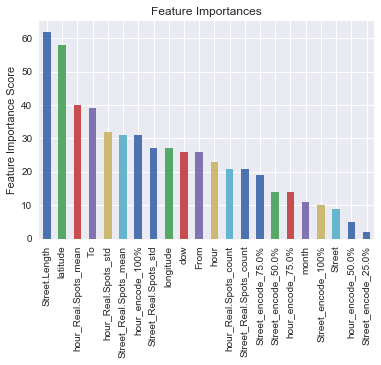

In [174]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=17)

modelfit(xgb1, train1, train1.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1).columns, 'any_spot')

In [164]:
np.mean(val['any_spot'] == (xgb1.predict(val1.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1))))

0.70454545454545459


Model Report
Accuracy : 0.7534
AUC Score (Train): 0.835421


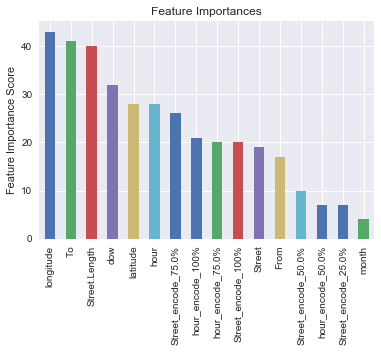

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11ab6afd0>>
Traceback (most recent call last):
  File "/Users/tyler/anaconda2/envs/fastai/lib/python3.6/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


In [165]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=2,
 min_child_weight=1,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=17)

modelfit(xgb2, train2, train2.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1).columns, 'any_spot')


Model Report
Accuracy : 0.8364
AUC Score (Train): 0.918536


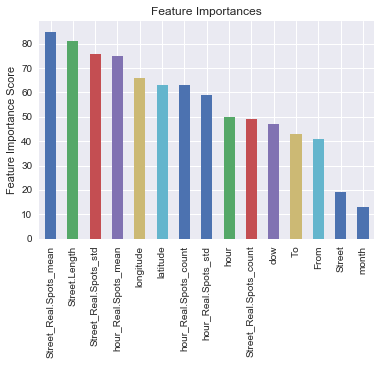

In [166]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=2,
 min_child_weight=1,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=17)

modelfit(xgb3, train3, train3.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1).columns, 'any_spot')

In [167]:
val_pred = np.mean([xgb1.predict_proba(val1.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1)),
                    xgb2.predict_proba(val2.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1)), 
                    xgb3.predict_proba(val3.drop(['Real.Spots', 'any_spot', 'Date', 'Time'], axis = 1))], axis = 0)[:, 1] > 0.5

In [168]:
np.mean(val['any_spot'] == (val_pred > 0.5))

0.70909090909090911

In [169]:
test1 = t1.transform(test)
test2 = t2.transform(test)
test3 = t3.transform(test)

In [170]:
test_pred = np.mean([xgb1.predict_proba(test1.drop(['id', 'Date', 'Time'], axis = 1)),
                    xgb2.predict_proba(test2.drop(['id', 'Date', 'Time'], axis = 1)), 
                    xgb3.predict_proba(test3.drop(['id', 'Date', 'Time'], axis = 1))], axis = 0)[:,1] > 0.5

In [171]:
pd.DataFrame({'id': test1['id'], 'any_spot' : test_pred}).set_index('id').to_csv('../predictions/cv_xgboost.csv')